# Imports

In [425]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import subprocess
import seaborn as sns
import seaborn.objects as so
from glob2 import glob

In [426]:
import mir_eval as me

In [427]:
dcml_chordtype_map = {
    "M": "major",
    "m": "minor",
    "Mm7": "dominant-7th",
    "o": "diminished",
    "o7": "full-diminished",
    "mm7": "minor-7th",
    "%7": "half-diminished",
    "MM7": "major-7th",
    "+": "augmented",
    "mM7": "minor-major-7th",
    "+7": "augmented-7th",
}

----

## Loading the Results
Loads all json files from the given folders

In [428]:
cols = ['id', 'corpus', 'piece', 'algorithm', 'accuracy', 'likelihood', 'chordLabels', 'slices','runTime', 'reruns']

In [429]:
def load_dataset(path):
    jsonFiles = glob(path + '/*/*/*/*.json')
    df = pd.DataFrame(columns=cols) 
    lbls = pd.DataFrame(columns=["piece", "corpus", "labels"])
    fails = []
    successes = 0
    for jsonFile in jsonFiles:
        try:
            with open(jsonFile, 'r') as f:
                data = json.loads(f.read())
        except:
            fails.append(jsonFile)
            continue
        successes += 1

        newLbls = pd.DataFrame([{"corpus":data['corpus'], "piece":data["piece"], "labels": data["groundTruth"]}])
        lbls = pd.concat([lbls, newLbls])

        newdf = pd.json_normalize(data, record_path = ['results'], 
            meta = ['id','corpus', 'piece','algorithm'])
        
        
        
        #newdf['groundTruth']= data['groundTruth']
        df = pd.concat([df, newdf])
    
    #results["experiment"] = results.index.get_level_values(0)
    df["experiment"] = df["id"].apply(lambda x: x.split("_")[1] if "_" in x else np.nan)
    df["id"] = df["id"].apply(lambda x: x.split("_")[0] if "_" in x else np.nan)
    df = df.dropna(subset=["experiment"])
    results = df.set_index(["experiment","id","corpus", "piece"])
    print ("Parsed {} runs succesfully, consisting of {} unique experiments with {} failed runs".format(successes, results.index.levels[0].nunique(), len(fails)))
    return (results,lbls.set_index(["corpus", "piece"]))

Load all runs - takes ~20s

In [430]:
(results,groundTruth) = load_dataset("outputs")

Parsed 1687 runs succesfully, consisting of 2 unique experiments with 1447 failed runs


# Organising results

In [431]:
#results.dropna(subset="accuracy")

In [432]:
#print(" ".join(list(results.index.levels[2].unique())))

# Stochastic beam search hyperparameters

### Choose specific experiement
202304-1700-0801 is the first experiment ran.
Includes 795 total runs. 
With Beam width 1-20 and reservoirs 200-4000 with gaps of 200.
Timeout was 400s, and only 72 runs completed within the time.

Next run will increase the timeout to 1000s, and narrow in the grid search region.

In [433]:
exp_id = "202304-1700-0801"

In [434]:
exp_df = results.xs(exp_id,level=1)

In [435]:
stochastic_params_df = exp_df.xs("stochastic-all-params",level=0)

In [436]:
stochastic_params_df['beamwidth'] = stochastic_params_df["algorithm"].apply(lambda s: int(s.split("_")[1]))
stochastic_params_df['reservoirsize'] = stochastic_params_df["algorithm"].apply(lambda s: int(s.split("_")[2]))


/tmp/ipykernel_342/1120307960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stochastic_params_df['beamwidth'] = stochastic_params_df["algorithm"].apply(lambda s: int(s.split("_")[1]))
/tmp/ipykernel_342/1120307960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stochastic_params_df['reservoirsize'] = stochastic_params_df["algorithm"].apply(lambda s: int(s.split("_")[2]))


## Accuracy, loglikelihood and runtime

In [437]:
def get_avgs(df, value):
    g = df.dropna(subset=value).groupby(['beamwidth','reservoirsize'])
    df_means = g[value].mean()
    return df_means.loc[:,:].reset_index().pivot(index='reservoirsize', columns='beamwidth', values=value)

In [438]:
acc_avgs = get_avgs(stochastic_params_df, 'accuracy')
lik_avgs = get_avgs(stochastic_params_df, 'likelihood')
run_avgs = get_avgs(stochastic_params_df, 'runTime')

## Plot hyperparemter results

In [439]:
def create_heatmap(xs, ax, vmin, vmax,cmap):
    lbls = xs.applymap(lambda v: "{:.2f}".format(v) if v in [np.nanmax(xs.values),np.nanmin(xs.values)]else '')
    return sns.heatmap(xs,
            square=True,
            ax=ax,
            cmap=cmap,
            fmt='',
            annot=lbls, # Label the maximum value
            annot_kws={'fontsize':11},
            mask=xs.isna(),
            vmax=vmax,
            vmin=vmin,
            linewidth=0.01)

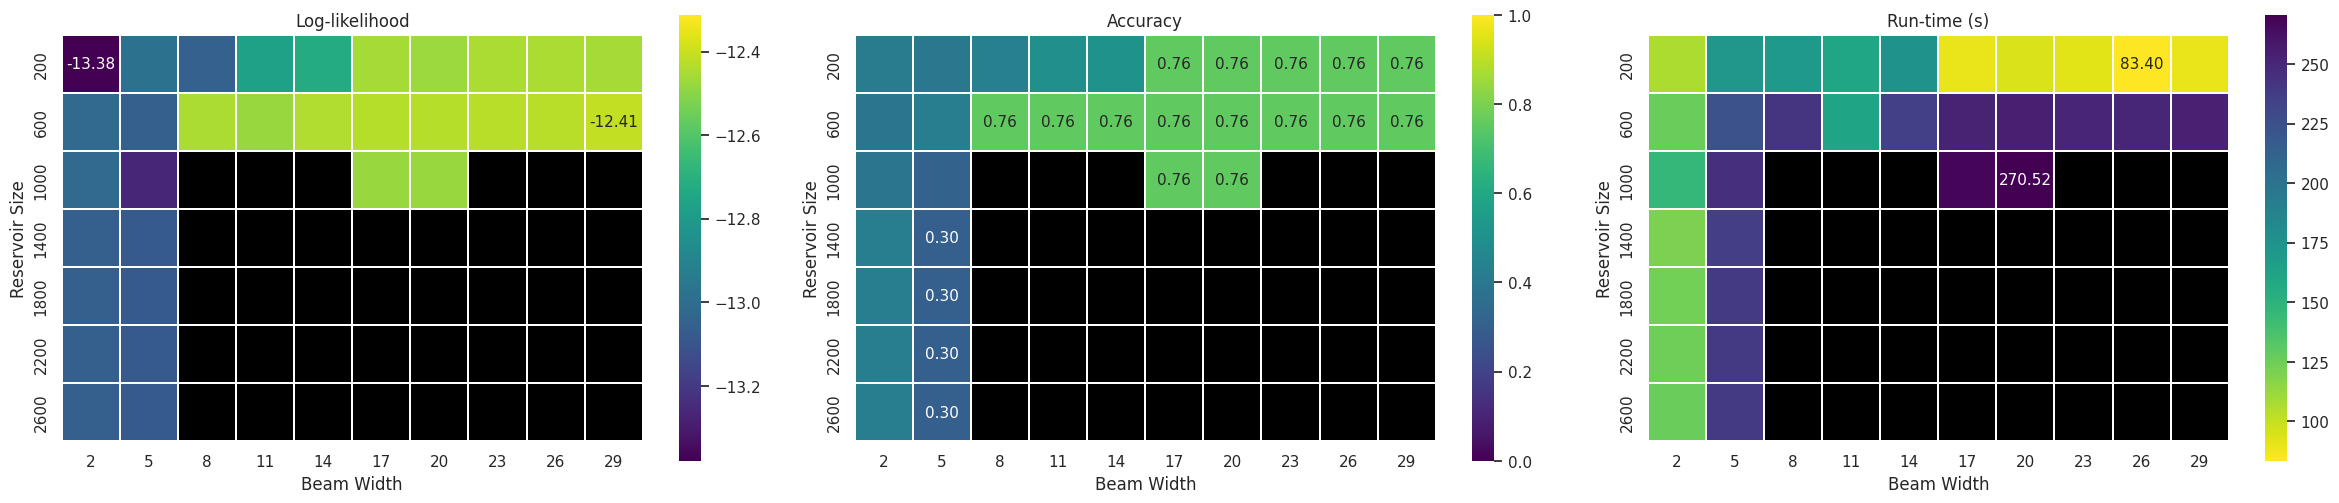

In [440]:
fig, ax = plt.subplots(1, 3, figsize=(24,5),gridspec_kw={'width_ratios': [1,1,1]})

cmap = sns.color_palette("viridis", as_cmap=True)
cmap.set_bad(color="black")

l = create_heatmap(lik_avgs, ax[0], lik_avgs.min().min(), lik_avgs.max().max()+ (lik_avgs.max().max()-lik_avgs.min().min()) * 0.1, cmap)
a = create_heatmap(acc_avgs, ax[1], 0, 1, cmap)
r = create_heatmap(run_avgs, ax[2], run_avgs.min().min(), run_avgs.max().max(), cmap.reversed())

ax[0].set_title('Log-likelihood')
ax[1].set_title('Accuracy')
ax[2].set_title('Run-time (s)')

for a in ax:
    a.set_xlabel('Beam Width')
    a.set_ylabel('Reservoir Size')


plt.tight_layout()
plt.savefig('plots/stochbeamsearchgridsearch-{}-1.png'.format(exp_id), dpi=180)

# Analysis on latest experiment

In [441]:
results = results.drop(["id"],axis=1)

KeyError: "['id'] not found in axis"

In [ ]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])

In [ ]:
agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).agg([np.mean, np.std])

In [ ]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).errors()

In [ ]:
agm = results.drop(["chordLabels", "slices","runTime","likelihood"], axis=1).groupby(["corpus", "algorithm"]).agg([np.std])

In [ ]:
errs = agm.reset_index()["accuracy"]["std"].fillna(0)

In [ ]:
a = results.drop(["chordLabels", "slices"], axis=1)

In [ ]:
std_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)

In [ ]:
acc_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

## Plot Accuracy Chart

In [ ]:
sns.set()  # use Seaborn styles
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
#acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
#plt.ylabel('Accuracy')
#plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

# Close Error Analysis

Attributes: chord type, root note, etc

#### Zoom in on ABC: n02op18-2_03

In [ ]:
groundTruth.loc['ABC','n02op18-2_03']

In [ ]:
results

In [ ]:
ex = results.loc['schumann_kinderszenen','n04']

In [ ]:
ex[["algorithm", "accuracy", "likelihood", "runTime"]]